# <span style="color:#84b6f4;">Identificación de actores</span>

### <span style="color:#77dd77;">Formación del DataFrame</span>

En este ejemplo, trataremos de identificar a Will Smith en diferentes imágenes. Comenzamos creando el DataFrame con una serie de imágenes que se han recopilado, etiquetando como 1 las imágenes en las que aparece Will Smith y como 0 las imágenes en las que no aparece:

In [1]:
import pandas as pd
import os
import random

# Directorio en el que se encuentran las imágenes de Will Smith
will_directory = os.getcwd() + '/resources/willSmithImages'

# Directorio en el que se encuentran las imágenes sin Will Smith
other_actors_directory = os.getcwd() + '/resources/otherActorsImages'

data = []

# Etiquetamos como 1 las imágenes en las que aparece Will Smith
for image in os.listdir(will_directory):
    image_url = os.path.join(will_directory, image)
    data.append({"image": image_url, "label": 1})

# Etiquetamos como 0 las imágenes en las que no aparece Will Smith
for image in os.listdir(other_actors_directory):
    ruta_imagen = os.path.join(other_actors_directory, image)
    data.append({"image": ruta_imagen, "label": 0})

# Desordenamos aleatoriamente los datos
random.shuffle(data)

# Creamos el DataFrame
df = pd.DataFrame(data)

Mostramos las 10 primeras imágenes, en escala de grises y tras haber sido preprocesadas:

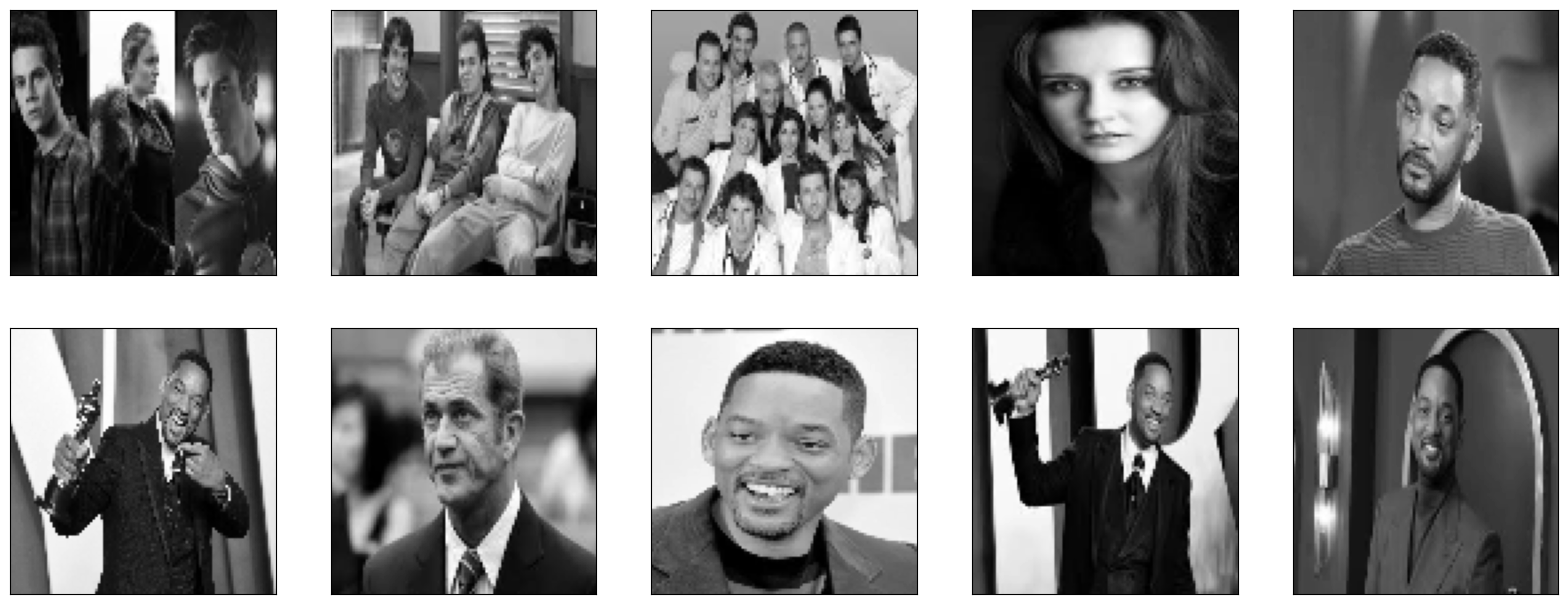

In [2]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20, 20))

IMG_SIZE = 100

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(url):
    image = cv2.imread(url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

# Mostramos las 10 primeras imágenes
for i, row in df.head(10).iterrows():
    image_url = row['image']
    image = load_and_preprocess_image(image_url)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap='gray')

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [3]:
import numpy as np

images = []
labels = []

# Cargamos las imágenes y etiquetas asociadas del DataFrame en "images" y "labels"
for i, row in df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    images.append(image)
    labels.append(row['label'])

images = np.array(images).astype(float) / 255
labels = np.array(labels)

### <span style="color:#77dd77;">Aumento de datos</span>

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

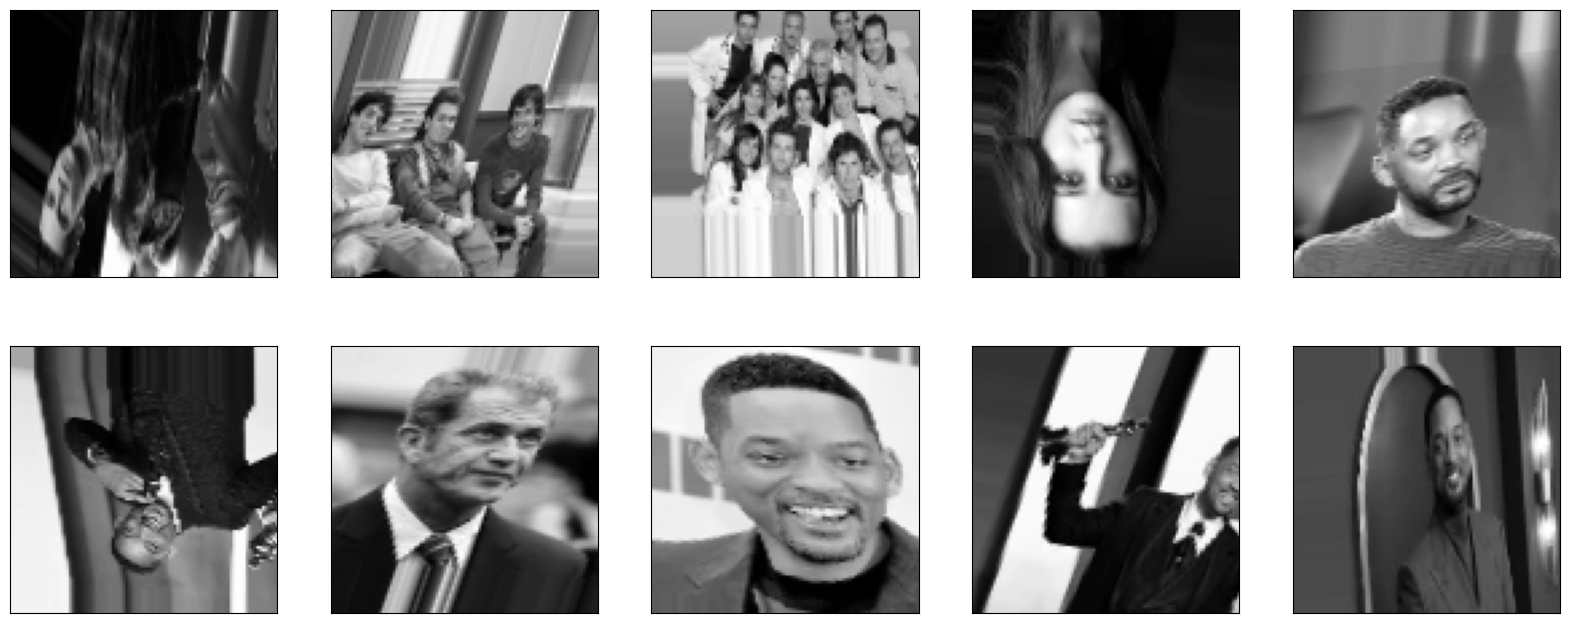

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajustamos el generador al conjunto de imágenes original
datagen.fit(images)

plt.figure(figsize=(20,8))

# Obtenemos un lote de imágenes aumentadas
for image, label in datagen.flow(images, labels, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    break  # Rompemos el bucle después de mostrar un lote

### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

In [5]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

# Creamos el modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=100, batch_size=32,
    validation_data=(test_images, test_labels),
    steps_per_epoch=int(np.ceil(len(train_images) / float(32))),
    validation_steps=int(np.ceil(len(test_images) / float(32)))
)

Epoch 1/100
23/23 [==============================] - 5s 185ms/step - loss: 0.7093 - accuracy: 0.4922 - val_loss: 0.6913 - val_accuracy: 0.5413
Epoch 2/100
23/23 [==============================] - 4s 183ms/step - loss: 0.6956 - accuracy: 0.5078 - val_loss: 0.6982 - val_accuracy: 0.4587
Epoch 3/100
23/23 [==============================] - 4s 182ms/step - loss: 0.6921 - accuracy: 0.5007 - val_loss: 0.6949 - val_accuracy: 0.4620
Epoch 4/100
23/23 [==============================] - 4s 184ms/step - loss: 0.6922 - accuracy: 0.5007 - val_loss: 0.6882 - val_accuracy: 0.5611
Epoch 5/100
23/23 [==============================] - 4s 186ms/step - loss: 0.6973 - accuracy: 0.5233 - val_loss: 0.6890 - val_accuracy: 0.5182
Epoch 6/100
23/23 [==============================] - 4s 183ms/step - loss: 0.6784 - accuracy: 0.5856 - val_loss: 0.6828 - val_accuracy: 0.5479
Epoch 7/100
23/23 [==============================] - 4s 183ms/step - loss: 0.6539 - accuracy: 0.6195 - val_loss: 0.6759 - val_accuracy: 0.5611

### <span style="color:#77dd77;">Evaluación</span>

Para finalizar, vamos a evaluar los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Realizamos las predicciones con los datos de prueba
test_predictions = model.predict(test_images)
test_predictions_rounded = np.round(test_predictions)

# Evaluamos el modelo con diferentes métricas
accuracy = accuracy_score(test_labels, test_predictions_rounded)
f1 = f1_score(test_labels, test_predictions_rounded)
confusion = confusion_matrix(test_labels, test_predictions_rounded)

# Mostramos los resultados
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(confusion)

10/10 [==============================] - 0s 37ms/step
Accuracy: 0.7458745874587459
F1 Score: 0.7768115942028985
[[ 92  47]
 [ 30 134]]
